* 映画の興行収入を予測
  * データ
    * (URL)
      * データは「スッキリわかる機械学習入門(インプレス)」より引用  
        (著作権は株式会社フレアリンクに帰属、CC BY-SA 4.0(要約))
    * つぶやき数、主演男優の露出度、原作有無から、最終興行収入を予測

In [1]:
# google colab で実行する場合は、次の行の先頭の # を削除してこのブロックを実行する
#!wget https://raw.githubusercontent.com/KHiraGit/sudspg_ds/main/ml04_sukkiri_ml_cinema.xlsx
#!pip install japanize-matplotlib

In [2]:
# ライブラリのインポート
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import statistics

In [3]:
# データが格納されたエクセルファイルをデータフレームに読み込み、
# 行数と列数を確認、先頭5行を表示
df1 = pd.read_excel('ml04_sukkiri_ml_cinema.xlsx')
print('date frame shape', df1.shape)
df1.head()

date frame shape (100, 6)


,cinema_id,SNS1,SNS2,actor,original,sales
0,1375,291.0,1044,8808.994029,0,9731
1,1000,363.0,568,10290.709370,1,10210
2,1390,158.0,431,6340.388534,1,8227
3,1499,261.0,578,8250.485081,0,9658
4,1164,209.0,683,10908.539550,0,9286


In [4]:
## 欠損値の確認 (pandasのisnull関数を利用)
# any(axis=0) で各列に欠損値があるかを確認
df1.isnull().any(axis=0)

cinema_id    False
SNS1          True
SNS2         False
actor         True
original     False
sales        False
dtype: bool

In [5]:
## 欠損値の穴埋め (平均値で穴埋めしたデータフレームdf2を作成)
# df.mean()で各列の平均を求め、fillna()で欠損箇所に挿入
df2 = df1.fillna(df1.mean())
# 欠損を穴埋めした結果を確認
df2.isnull().any(axis=0)

cinema_id    False
SNS1         False
SNS2         False
actor        False
original     False
sales        False
dtype: bool

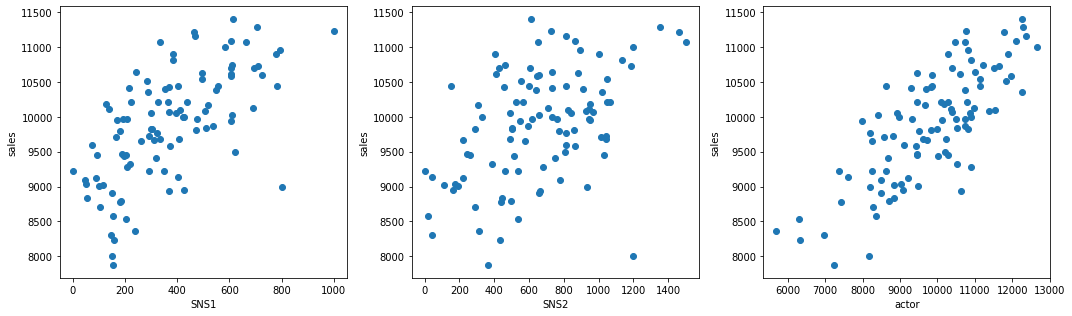

In [6]:
## 散布図を作成して外れ値を確認
# 散布図を3つ横に並べる設定 : subplots の行
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))

# 各散布図の縦軸に使うデータ列の名称をリストで準備
columns = ['SNS1', 'SNS2', 'actor']

# forループでリストの各列の散布図を作成
for i in range(len(columns)):
    ax[i].set_xlabel(columns[i])  # 横軸のラベルを設定
    ax[i].set_ylabel('sales')     # 縦軸のラベルを設定
    ax[i].scatter(df2[columns[i]], df2['sales']) # 散布図を作成
plt.tight_layout()  # ラベルの重なりを避けるためのサイズ調整を実施
plt.show()  # グラフを表示

SNS1-sales outlier [50] 
     cinema_id   SNS1  SNS2        actor  original  sales
50       1827  800.0   934  8206.568734         0   9000 

SNS2-sales outlier [30] 
     cinema_id   SNS1  SNS2        actor  original  sales
30       1855  149.0  1200  8173.096892         0   8000 

date frame shape (98, 6)


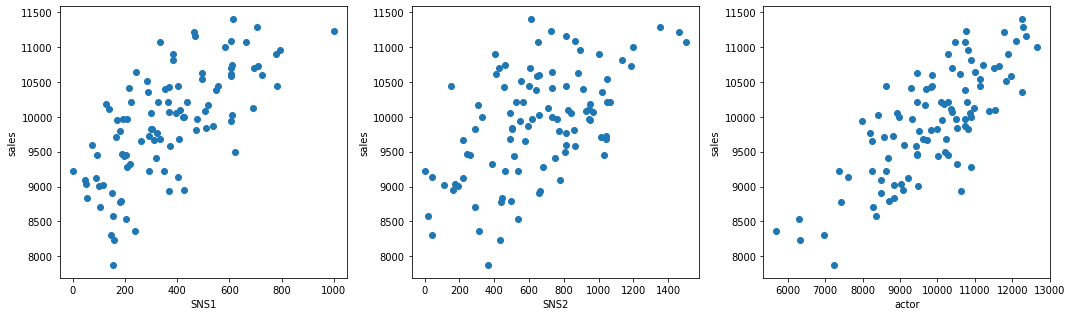

In [7]:
## 外れ値を含む行を削除
# SNS1-sales の右下の点のインデックスを取得
hazure_SNS1_index = df2[(df2['SNS1'] > 700) & (df2['sales'] < 9500)].index.to_list()
print('SNS1-sales outlier', hazure_SNS1_index, '\n', df2.loc[hazure_SNS1_index], '\n')

# SNS2-sales の右下の点のインデックスを取得
hazure_SNS2_index = df2[(df2['SNS2'] > 1000) & (df2['sales'] < 8500)].index.to_list()
print('SNS2-sales outlier', hazure_SNS2_index, '\n', df2.loc[hazure_SNS2_index], '\n')

# 上記の点の行をデータフレームから除去 (list+list でリストを結合)
df3 = df2.drop(hazure_SNS1_index + hazure_SNS2_index, axis=0)
print('date frame shape', df3.shape)

# 外れ値を除去した後のデータの分布を確認
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5))
columns = ['SNS1', 'SNS2', 'actor']
for i in range(len(columns)):
    ax[i].set_xlabel(columns[i])  # 横軸のラベルを設定
    ax[i].set_ylabel('sales')     # 縦軸のラベルを設定
    ax[i].scatter(df3[columns[i]], df3['sales']) # 散布図を作成
plt.tight_layout()  # ラベルの重なりを避けるためのサイズ調整を実施
plt.show()  # グラフを表示

In [8]:
## 学習・検証用にデータを分割
# データフレームの SNS1,SNS2,actor,originalを入力データとして変数xに代入、salesを正解ラベルとして変数yに代入
x = df3[['SNS1', 'SNS2', 'actor', 'original']]
y = df3['sales']

# データを学習用と検証用に分割 (test_sizeで検証データの比率を指定(0.0-1.0の間), random_stateは乱数シード)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
print(len(x_train), len(x_test), len(y_train), len(y_test)) # それぞれのデータ数を確認

73 25 73 25


In [9]:
# 回帰モデルを作成
model = LinearRegression()

# 回帰モデルを学習用データで学習
model.fit(x_train, y_train)

LinearRegression()

In [10]:
# ダミーデータを用意し、その予測で作成したモデルの動作を確認
x_dummy = pd.DataFrame([[200, 400, 9000, 1]], 
                       columns=['SNS1','SNS2','actor','original'])
model.predict(x_dummy)

array([9433.34138901])

In [15]:
## 検証用データを利用してモデルを評価
# 学習したモデルを使い、検証用データの入力データから最終興行収入を予測
pred = model.predict(x_test)

# 平均絶対誤差、平均二乗誤差、決定係数を計算
print('平均絶対誤差', mean_absolute_error(y_pred=pred, y_true=y_test))
print('平均二乗誤差', mean_squared_error(y_pred=pred, y_true=y_test))
print('二乗平均平方根誤差', 
      math.sqrt(mean_squared_error(y_pred=pred, y_true=y_test)))
print('決定係数', model.score(x_test, y_test))
print('(参考) 学習データに対する決定係数', model.score(x_train, y_train))

平均絶対誤差 258.63085216199414
平均二乗誤差 95446.07725902612
二乗平均平方根誤差 308.9434855423013
決定係数 0.7768475740147733
(参考) 学習データに対する決定係数 0.7872531760902196


In [12]:
## 作成したモデルを確認
# モデルの式を確認
print(model.coef_) # モデルの係数を表示
print(model.intercept_) # モデルの切片を表示

[  1.33936552   0.58445685   0.26305028 204.55220007]
6359.6808313123


test_size=0.8 train_size=0.19999999999999996
(test) 平均絶対誤差の平均と分散 338.2445454460387 36.77144321676808
(train) 平均絶対誤差の平均と分散 251.68129735730832 47.83233725042243
(test) 平均平方二乗誤差の平均と分散 422.1169833311978 43.19314470006472
(train) 平均平方二乗誤差の平均と分散 313.1585061597985 60.76162674622321
(test) 決定係数の平均と分散 0.6971973090346117 0.0718438613601167
(train) 決定係数の平均と分散 0.8158116190948487 0.07559693892855354
test_size=0.5 train_size=0.5
(test) 平均絶対誤差の平均と分散 306.0188284167472 25.380556075498344
(train) 平均絶対誤差の平均と分散 277.37778671605173 22.747528361055515
(test) 平均平方二乗誤差の平均と分散 381.94783694642655 31.73873883279312
(train) 平均平方二乗誤差の平均と分散 348.02998481845043 29.641784135496135
(test) 決定係数の平均と分散 0.748648616245531 0.048373465724992265
(train) 決定係数の平均と分散 0.7931153941865655 0.03789487509463084
test_size=0.25 train_size=0.75
(test) 平均絶対誤差の平均と分散 301.2812486526829 39.59844418598704
(train) 平均絶対誤差の平均と分散 282.5238390794617 13.236281114552577
(test) 平均平方二乗誤差の平均と分散 372.8423929598066 51.264939039302526
(train) 平均平方二乗誤差の平均と分散 354

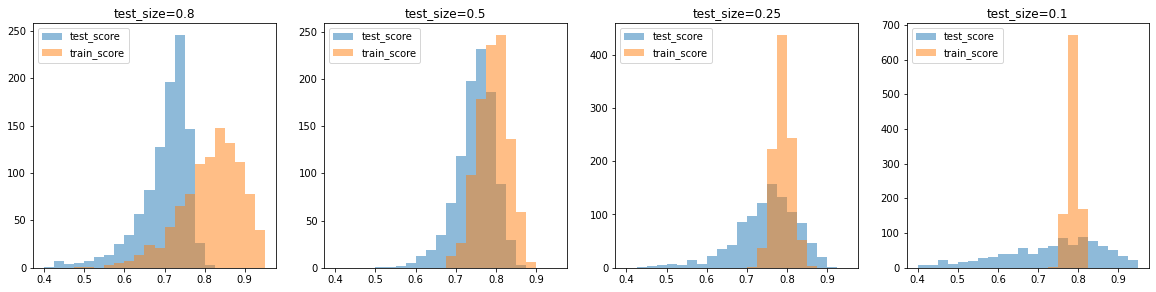

In [13]:
# スライド「データ分割のモデルへの影響」のグラフを作成するためのプログラム
# 散布図を3つ横に並べる設定 : subplots の行
fig, ax = plt.subplots(1, 4, figsize=(20, 4.5))
size = [0.5, 0.25, 0.1]
size = [0.8, 0.5, 0.25, 0.1]
test_mae = []
train_mae = []
test_mrse = []
train_mrse = []
test_score = []
train_score = []
for i in range(len(size)):
    test_mae.append([])
    train_mae.append([])
    test_mrse.append([])
    train_mrse.append([])
    test_score.append([])
    train_score.append([])
    for _rand_seed in range(1000):

        # データを学習用と検証用に分割 
        # (test_sizeで検証データの比率を指定(0.0-1.0の間), random_stateは乱数シード)
        x_train, x_test, y_train, y_test = \
            train_test_split(x, y, test_size=size[i], random_state=_rand_seed)

        # print(len(x_train), len(x_test), len(y_train), len(y_test)) # それぞれのデータ数を確認

        model = LinearRegression()    # 回帰モデルを作成
        model.fit(x_train, y_train)    # 回帰モデルを学習用データで学習

        test_pred = model.predict(x_test)
        test_mae[i].append(mean_absolute_error(y_pred=test_pred, y_true=y_test))
        test_mrse[i].append(math.sqrt(mean_squared_error(y_pred=test_pred, y_true=y_test)))

        train_pred = model.predict(x_train)
        train_mae[i].append(mean_absolute_error(y_pred=train_pred, y_true=y_train))
        train_mrse[i].append(math.sqrt(mean_squared_error(y_pred=train_pred, y_true=y_train)))

        test_score[i].append(model.score(x_test, y_test)) # 検証用データに対する決定係数
        train_score[i].append(model.score(x_train, y_train)) # 学習用データに対する決定係数

    # 性能の確認
    print(f'test_size={size[i]} train_size={1-size[i]}')
    print('(test) 平均絶対誤差の平均と分散', statistics.mean(test_mae[i]), statistics.stdev(test_mae[i]))
    print('(train) 平均絶対誤差の平均と分散', statistics.mean(train_mae[i]), statistics.stdev(train_mae[i]))
    print('(test) 平均平方二乗誤差の平均と分散', statistics.mean(test_mrse[i]), statistics.stdev(test_mrse[i]))
    print('(train) 平均平方二乗誤差の平均と分散', statistics.mean(train_mrse[i]), statistics.stdev(train_mrse[i]))
    print('(test) 決定係数の平均と分散', statistics.mean(test_score[i]), statistics.stdev(test_score[i]))
    print('(train) 決定係数の平均と分散', statistics.mean(train_score[i]), statistics.stdev(train_score[i]))


    # 各決定係数をヒストグラムに表示 (ビンの幅・数を揃えて、透過色で重ね合わせて表示)
    ax[i].set_title(f'test_size={size[i]}')
    ax[i].hist(test_score[i], alpha=0.5, label='test_score', range=(0.40, 0.95), bins=22)
    ax[i].hist(train_score[i], alpha=0.5, label='train_score', range=(0.40, 0.95), bins=22)
    ax[i].legend(loc='upper left')

plt.show()

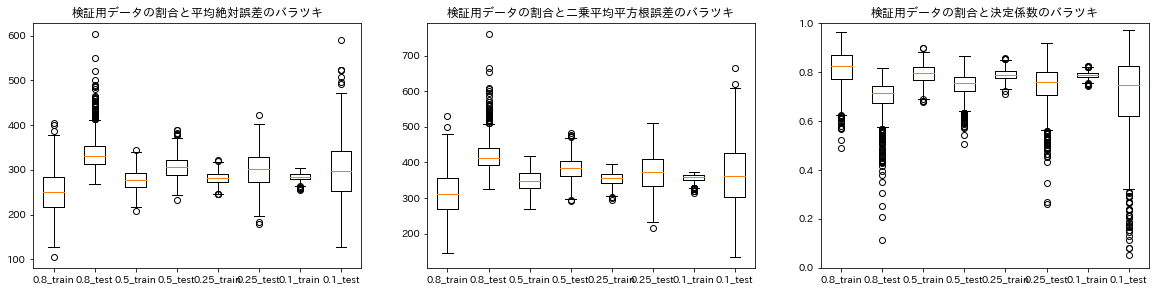

In [16]:
import japanize_matplotlib
fig, ax = plt.subplots(1, 3, figsize=(20, 4.5))
ax[0].set_title('検証用データの割合と平均絶対誤差のバラツキ')
ax[0].boxplot([train_mae[0], test_mae[0], train_mae[1], test_mae[1], train_mae[2], test_mae[2], train_mae[3], test_mae[3]])
ax[0].set_xticklabels(['0.8_train', '0.8_test', '0.5_train', '0.5_test', '0.25_train', '0.25_test', '0.1_train', '0.1_test'])
ax[1].set_title('検証用データの割合と二乗平均平方根誤差のバラツキ')
ax[1].boxplot([train_mrse[0], test_mrse[0], train_mrse[1], test_mrse[1], train_mrse[2], test_mrse[2], train_mrse[3], test_mrse[3]])
ax[1].set_xticklabels(['0.8_train', '0.8_test', '0.5_train', '0.5_test', '0.25_train', '0.25_test', '0.1_train', '0.1_test'])
ax[2].set_title('検証用データの割合と決定係数のバラツキ')
ax[2].set_ylim(0.0, 1.0)
ax[2].boxplot([train_score[0], test_score[0], train_score[1], test_score[1], train_score[2], test_score[2], train_score[3], test_score[3]])
ax[2].set_xticklabels(['0.8_train', '0.8_test', '0.5_train', '0.5_test', '0.25_train', '0.25_test', '0.1_train', '0.1_test'])
plt.show()
